Ratings sample:
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40

Movies sample:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


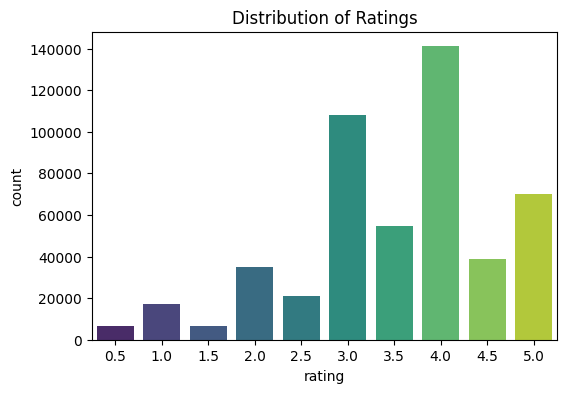


RMSE on sample = 0.9667


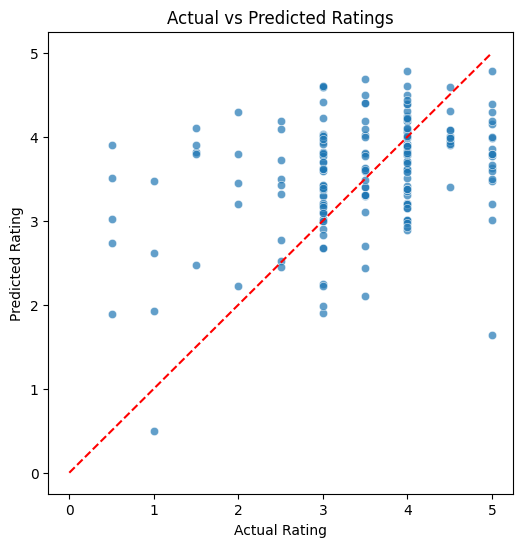

In [4]:
# Task 4: Movie Rating Prediction with MovieLens 20M (subset for speed)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt

# -----------------------------
# Step 1: Load Dataset
# -----------------------------
folder = "/kaggle/input/movielens-20m-dataset"

# Load a subset (500k rows for speed)
ratings = pd.read_csv(f"{folder}/rating.csv", nrows=500000)
movies = pd.read_csv(f"{folder}/movie.csv")

print("Ratings sample:")
print(ratings.head())
print("\nMovies sample:")
print(movies.head())

# -----------------------------
# Step 2: Visualization
# -----------------------------
plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of Ratings")
plt.show()

# -----------------------------
# Step 3: User-Movie Matrix
# -----------------------------
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')
user_movie_matrix_filled = user_movie_matrix.fillna(0)

# -----------------------------
# Step 4: Similarity
# -----------------------------
user_similarity = cosine_similarity(user_movie_matrix_filled)
user_similarity_df = pd.DataFrame(user_similarity, 
                                  index=user_movie_matrix.index, 
                                  columns=user_movie_matrix.index)

# -----------------------------
# Step 5: Predict Function
# -----------------------------
def predict_rating(user_id, movie_id, k=5):
    if movie_id not in user_movie_matrix:
        return np.nan
    
    sim_scores = user_similarity_df[user_id].drop(user_id, errors="ignore")
    movie_ratings = user_movie_matrix[movie_id].drop(user_id, errors="ignore")
    
    df = pd.concat([sim_scores, movie_ratings], axis=1)
    df.columns = ["similarity", "rating"]
    df = df.dropna()
    
    top_k = df.sort_values("similarity", ascending=False).head(k)
    if top_k["similarity"].sum() == 0:
        return np.nan
    
    prediction = np.dot(top_k["similarity"], top_k["rating"]) / top_k["similarity"].sum()
    return prediction

# -----------------------------
# Step 6: Evaluate on Small Sample
# -----------------------------
sample = ratings.sample(200, random_state=42)

predictions = []
for row in sample.itertuples():
    pred = predict_rating(row.userId, row.movieId, k=5)
    predictions.append(pred)

sample["predicted"] = predictions
sample = sample.dropna()

rmse = sqrt(mean_squared_error(sample["rating"], sample["predicted"]))
print(f"\nRMSE on sample = {rmse:.4f}")

# -----------------------------
# Step 7: Visualization
# -----------------------------
plt.figure(figsize=(6,6))
sns.scatterplot(x=sample["rating"], y=sample["predicted"], alpha=0.7)
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Actual vs Predicted Ratings")
plt.plot([0,5],[0,5],'r--')
plt.show()
